# Este es un intento de quitarle la chamba a Netflix

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import * 


In [3]:
spark = SparkSession \
    .builder \
    .appName("PySpark Recommender") \
    .getOrCreate()

In [ ]:
#https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/animes.csv
#https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/profiles.csv
#https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/reviews.csv


In [4]:
!wget https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/animes.csv
!wget https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/profiles.csv
!wget https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/reviews.csv

--2022-04-21 00:20:24--  https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/animes.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 74.125.129.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12073332 (12M) [text/csv]
Saving to: ‘animes.csv’

animes.csv          100%[===================>]  11.51M  --.-KB/s    in 0.07s   

2022-04-21 00:20:24 (170 MB/s) - ‘animes.csv’ saved [12073332/12073332]

--2022-04-21 00:20:24--  https://storage.googleapis.com/public-bucket-up-2022/Anime_Recommender/profiles.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 74.125.129.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8664114 (8.3M) [text/csv]
Saving to: ‘profiles.csv’

In [5]:
!ls

animes.csv  hadoop	    lost+found	  reviews.csv  sys	    war.txt
bin	    home	    media	  root	       tmp
boot	    initrd.img	    mnt		  run	       usr
copyright   initrd.img.old  opt		  sbin	       var
dev	    lib		    proc	  snap	       vmlinuz
etc	    lib64	    profiles.csv  srv	       vmlinuz.old


In [8]:
!hdfs dfs -mkdir /user/recommender
!hdfs dfs -copyFromLocal animes.csv /user/recommender
!hdfs dfs -copyFromLocal reviews.csv /user/recommender
!hdfs dfs -copyFromLocal profiles.csv /user/recommender

In [9]:
!hdfs dfs -ls /user/recommender

Found 3 items
-rw-r--r--   2 root hadoop   12073332 2022-04-21 00:25 /user/recommender/animes.csv
-rw-r--r--   2 root hadoop    8664114 2022-04-21 00:25 /user/recommender/profiles.csv
-rw-r--r--   2 root hadoop  685916744 2022-04-21 00:25 /user/recommender/reviews.csv


In [10]:
animes = spark.read.csv("/user/recommender/animes.csv", header = True)

In [12]:
animes.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+--------------------+--------------------+-------+----+
|                 uid|               title|            synopsis|               genre|               aired|            episodes|members|popularity|              ranked|               score|img_url|link|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----------+--------------------+--------------------+-------+----+
|               28891|Haikyuu!! Second ...|Following their p...|                null|                null|                null|   null|      null|                null|                null|   null|null|
|When they receive...| Karasuno agrees ...| they hope not on...| but also come up...| Hinata and Kagey...| one that could p...|   null|      null|                null|                null|   n

In [13]:
profiles = spark.read.csv("/user/recommender/profiles.csv", header = True)
profiles.show(5)

+---------------+------+------------+--------------------+--------------------+
|        profile|gender|    birthday|     favorites_anime|                link|
+---------------+------+------------+--------------------+--------------------+
| DesolatePsyche|  Male| Oct 2, 1994|['33352', '25013'...|https://myanimeli...|
|      baekbeans|Female|Nov 10, 2000|['11061', '31964'...|https://myanimeli...|
|           skrn|  null|        null|['918', '2904', '...|https://myanimeli...|
|   edgewalker00|  Male|       Sep 5|['5680', '849', '...|https://myanimeli...|
|aManOfCulture99|  Male|Oct 30, 1999|['4181', '7791', ...|https://myanimeli...|
+---------------+------+------------+--------------------+--------------------+
only showing top 5 rows



In [14]:
reviews = spark.read.csv("/user/recommender/reviews.csv", header = True)
reviews.show(5)

+--------------------+--------------+---------+----+-----+------+----+
|                 uid|       profile|anime_uid|text|score|scores|link|
+--------------------+--------------+---------+----+-----+------+----+
|              255938|DesolatePsyche|    34096|   "| null|  null|null|
|           more p...|          null|     null|null| null|  null|null|
|            Overall |          null|     null|null| null|  null|null|
|                  8 |          null|     null|null| null|  null|null|
|              Story |          null|     null|null| null|  null|null|
+--------------------+--------------+---------+----+-----+------+----+
only showing top 5 rows



In [16]:
reviews = spark.read.format('csv') \
    .option('header', True) \
    .option('delimiter', ",") \
    .option('multiline', True) \
    .option('escape', '"') \
    .option('inferSchema', "true") \
.load("/user/recommender/reviews.csv")

In [17]:
reviews.show(5)

+------+---------------+---------+--------------------+-----+--------------------+--------------------+
|   uid|        profile|anime_uid|                text|score|              scores|                link|
+------+---------------+---------+--------------------+-----+--------------------+--------------------+
|255938| DesolatePsyche|    34096|
           
    ...|    8|{'Overall': '8', ...|https://myanimeli...|
|259117|      baekbeans|    34599|
           
    ...|   10|{'Overall': '10',...|https://myanimeli...|
|253664|           skrn|    28891|
           
    ...|    7|{'Overall': '7', ...|https://myanimeli...|
|  8254|   edgewalker00|     2904|
           
    ...|    9|{'Overall': '9', ...|https://myanimeli...|
|291149|aManOfCulture99|     4181|
           
    ...|   10|{'Overall': '10',...|https://myanimeli...|
+------+---------------+---------+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [18]:
reviews.select('uid', 'anime_uid', 'score', 'scores').show(5)

+------+---------+-----+--------------------+
|   uid|anime_uid|score|              scores|
+------+---------+-----+--------------------+
|255938|    34096|    8|{'Overall': '8', ...|
|259117|    34599|   10|{'Overall': '10',...|
|253664|    28891|    7|{'Overall': '7', ...|
|  8254|     2904|    9|{'Overall': '9', ...|
|291149|     4181|   10|{'Overall': '10',...|
+------+---------+-----+--------------------+
only showing top 5 rows



In [25]:
df = reviews.select(["scores"]).collect()

In [26]:
df

[Row(scores="{'Overall': '8', 'Story': '8', 'Animation': '8', 'Sound': '10', 'Character': '9', 'Enjoyment': '8'}"),
 Row(scores="{'Overall': '10', 'Story': '10', 'Animation': '10', 'Sound': '10', 'Character': '10', 'Enjoyment': '10'}"),
 Row(scores="{'Overall': '7', 'Story': '7', 'Animation': '9', 'Sound': '8', 'Character': '8', 'Enjoyment': '8'}"),
 Row(scores="{'Overall': '9', 'Story': '9', 'Animation': '9', 'Sound': '10', 'Character': '10', 'Enjoyment': '9'}"),
 Row(scores="{'Overall': '10', 'Story': '10', 'Animation': '8', 'Sound': '9', 'Character': '10', 'Enjoyment': '10'}"),
 Row(scores="{'Overall': '10', 'Story': '9', 'Animation': '10', 'Sound': '10', 'Character': '10', 'Enjoyment': '10'}"),
 Row(scores="{'Overall': '6', 'Story': '6', 'Animation': '9', 'Sound': '8', 'Character': '6', 'Enjoyment': '6'}"),
 Row(scores="{'Overall': '8', 'Story': '7', 'Animation': '9', 'Sound': '0', 'Character': '0', 'Enjoyment': '9'}"),
 Row(scores="{'Overall': '10', 'Story': '10', 'Animation': '9'

In [27]:
reviews.groupBy("uid").count().sort("count", ascending = False).show()

+------+-----+
|   uid|count|
+------+-----+
|322786|    4|
|321498|    4|
|321183|    4|
|321837|    4|
|321144|    4|
|321148|    4|
| 11936|    3|
|243640|    3|
|268754|    3|
|216426|    3|
|209326|    3|
| 87023|    3|
|135267|    3|
|258274|    3|
|237278|    3|
|287951|    3|
|209585|    3|
|207045|    3|
|244135|    3|
|  2748|    3|
+------+-----+
only showing top 20 rows



In [28]:
reviews.describe('score').show()

+-------+-----------------+
|summary|            score|
+-------+-----------------+
|  count|           192112|
|   mean|7.570235071208462|
| stddev|2.255167441795992|
|    min|                0|
|    max|               11|
+-------+-----------------+



In [29]:
reviews_usable = reviews.select('uid', 'anime_uid', 'score', 'scores')

In [30]:
from pyspark.ml.recommendation import ALS


In [31]:
training, test = reviews_usable.randomSplit([0.8, 0.2])

In [32]:
als = ALS(maxIter = 10, regParam = 0.01, userCol = 'uid', itemCol='anime_uid', ratingCol='score')

In [33]:
model = als.fit(training)

In [34]:
model

ALSModel: uid=ALS_637b509046b2, rank=10

In [35]:
predictions = model.transform(test)

In [36]:
predictions

DataFrame[uid: int, anime_uid: int, score: int, scores: string, prediction: float]

In [37]:
predictions.show()

+------+---------+-----+--------------------+----------+
|   uid|anime_uid|score|              scores|prediction|
+------+---------+-----+--------------------+----------+
| 37526|     1829|    7|{'Overall': '7', ...|       NaN|
|128289|     8086|    9|{'Overall': '9', ...|       NaN|
| 31537|     5300|    9|{'Overall': '9', ...|  8.999608|
| 32866|     8086|    6|{'Overall': '6', ...|       NaN|
|247132|    25517|    9|{'Overall': '9', ...|   8.99942|
|289647|     1829|    6|{'Overall': '6', ...|       NaN|
| 41639|     1829|    3|{'Overall': '3', ...|       NaN|
|242597|     6336|    4|{'Overall': '4', ...| 3.9997594|
| 32882|     8086|    7|{'Overall': '7', ...|       NaN|
|257343|    30654|   10|{'Overall': '10',...|       NaN|
|257343|    30654|   10|{'Overall': '10',...|       NaN|
| 32515|     8086|    7|{'Overall': '7', ...|       NaN|
| 15242|     1829|    9|{'Overall': '9', ...|       NaN|
|245066|     5300|   10|{'Overall': '10',...|  9.999564|
|210113|     6336|    3|{'Overa

In [42]:
from pyspark.sql import *
import pyspark.sql.functions as F

new_pred = predictions.filter(~F.isnan(predictions.prediction)).collect()

In [43]:
import numpy as np
import matplotlib.pyplot as plt

lst_arr = np.array(new_pred)


In [44]:
scores = lst_arr[:, 2].astype(float)
preds = lst_arr[:, 4].astype(float)
diff = scores - preds

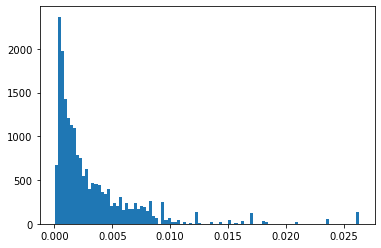

In [45]:
plt.hist(diff, bins = 100)
plt.show()

In [46]:
spark.stop()